# Basics > Compare Means

<div class="alert alert-info">Compare the means of two or more variables or groups in the data</div>

The compare means t-test is used to compare the mean of a variable in one group to the mean of the same variable in one, or more, other groups. The null hypothesis for the difference between the groups in the population is set to zero. We test this hypothesis using sample data.

We can perform either a one-tailed test (i.e., `less than` or `greater than`) or a two-tailed test (see the ‘Alternative hypothesis’ dropdown). We use one-tailed tests to evaluate if the available data provide evidence that the difference in sample means between groups is less than (or greater than ) zero.

In [8]:
import matplotlib as mpl
import pyrsm as rsm

# increase plot resolution
mpl.rcParams["figure.dpi"] = 100

In [9]:
## setup pyrsm for autoreload 
%reload_ext autoreload
%autoreload 2
%aimport pyrsm

# Example

We have access to the nine-month academic salary for Assistant Professors, Associate Professors and Professors in a college in the U.S (2008-09). The data were collected as part of an on-going effort by the college’s administration to monitor salary differences between male and female faculty members.

The data are part of the CAR package and are linked to the book: Fox J. and Weisberg, S. (2011) An R Companion to Applied Regression, Second Edition Sage.



In [10]:
salary, salary_description = rsm.load_data(pkg="basics", name="salary")
salary

,salary,rank,discipline,yrs.since.phd,yrs.service,sex
0,139750,Prof,B,19,18,Male
1,173200,Prof,B,20,16,Male
2,79750,AsstProf,B,4,3,Male
3,115000,Prof,B,45,39,Male
4,141500,Prof,B,40,41,Male
...,...,...,...,...,...,...
392,103106,Prof,A,33,30,Male
393,150564,Prof,A,31,19,Male
394,101738,Prof,A,42,25,Male
395,95329,Prof,A,25,15,Male


In [11]:
rsm.md(salary_description)

## Salaries for Professors

### Description

The 2008-09 nine-month academic salary for Assistant Professors, Associate Professors and Professors in a college in the U.S. The data were collected as part of the on-going effort of the college's administration to monitor salary differences between male and female faculty members. A data frame with 397 observations on the following 6 variables.

### Variables

- rank = a factor with levels AsstProf, AssocProf, and Prof
- discipline = a factor with levels A ('theoretical' departments) or B ('applied' departments)
- yrs.since.phd = years since PhD
- yrs.service = years of service
- sex = a factor with levels Female and Male
- salary = nine-month salary, in dollars

### Source

Fox J. and Weisberg, S. (2011) An R Companion to Applied Regression, Second Edition Sage.


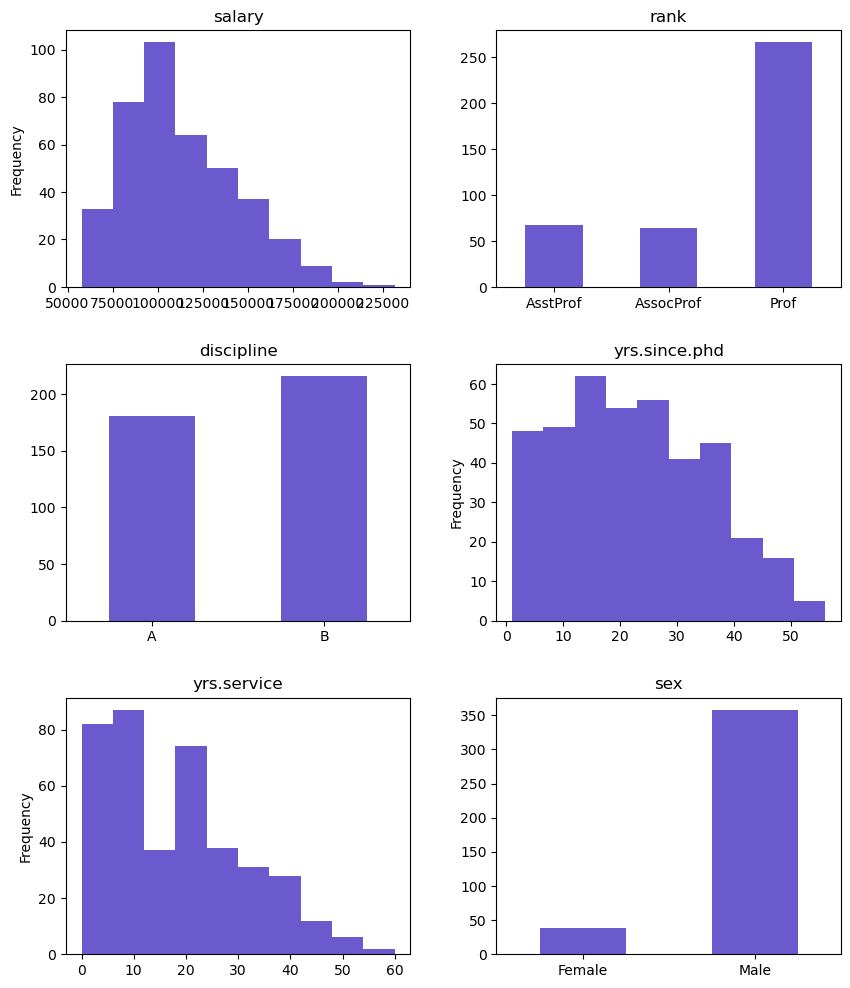

In [12]:
rsm.distr_plot(salary)

Suppose we want to test if professors of lower rank earn lower salaries compared to those of higher rank.

Below is the way to do it in python.

In [13]:
cm = rsm.basics.compare_means({"salary": salary}, var1="rank", var2="salary", alt_hyp="less")
cm.summary()

Pairwise mean comparisons (t-test)
Data      : salary
Variables : rank, salary
Samples   : independent
Confidence: 0.95
Adjustment: None
     rank       mean   n  n_missing        sd       se       me
 AsstProf  80775.985  67          0  8174.113  998.627 1993.823
AssocProf  93876.438  64          0 13831.700 1728.962 3455.056
     Prof 126772.109 266          0 27718.675 1699.541 3346.322
           Null hyp.                    Alt. hyp.       diff p.value    
AsstProf = AssocProf AsstProf less than AssocProf -13100.452  < .001 ***
     AsstProf = Prof      AsstProf less than Prof -45996.124  < .001 ***
    AssocProf = Prof     AssocProf less than Prof -32895.672  < .001 ***


# Radiant for Python App: Single Mean

To test this hypothesis using Radiant for Python, we first select professor `rank` and select `salary` as the numerical variable to compare across ranks. In the `Choose combinations` box select all available entries to conduct pair-wise comparisons across the three levels. Note that removing all entries will automatically select all combinations. We are interested in a one-sided hypothesis (i.e., `less than`).

These steps will generate the same output as shown above and will generate the required Python code to create the desired results.

> Note: The app will continue running until you press the `Stop` button in the app navigation bar or the stop button next to the notebook cell

In [14]:
rsm.radiant.compare_means({"salary": salary}, {"salary": salary_description}, open=True)


Listening on http://0.0.0.0:8000
Pyrsm and Radiant are open source tools and free to use. If you
are a student or instructor using pyrsm or Radiant for a class,
as a favor to the developers, please send an email to
<radiant@rady.ucsd.edu> with the name of the school and class.
If you are using Radiant in your company, as a favor to the
developer, please share the name of your company and what types
of activites you are supporting with the tool.
Invalid plot type


```python
import pyrsm as rsm

# salary = pd.read_parquet('salary.parquet')
cm = rsm.basics.compare_means(
    data={"salary": salary},
    var1="rank",
    var2="salary",
    comb=["AsstProf:AssocProf", "AsstProf:Prof", "AssocProf:Prof"],
    alt_hyp="less",
)
cm.plot(plots="bar")

```

<p align="center">
<img src="figures_basics/compare_means_summary.png">
</p>

The first two blocks of output show basic information about the test (e.g., selected variables and confidence levels) and summary statistics (e.g., mean, standard deviation, margin or error, etc. per group). The final block of output shows the following:

- `Null hyp.` is the null hypothesis and `Alt. hyp.` the alternative hypothesis
- `diff` is the difference between the sample means for two groups (e.g., 80775.99 - 93876.44 = -13100.45). If the null hypothesis is true we expect this difference to be small (i.e., close to zero)
- `p.value` is the probability of finding a value as extreme or more extreme than `diff` if the null hypothesis is true
- `se` is the standard error (i.e., the standard deviation of the sampling distribution of `diff`)
- `t.value` is the t statistic associated with `diff` that we can compare to a t-distribution (i.e., `diff` / `se`)
- `df` is the degrees of freedom associated with the statistical test. Note that the Welch approximation is used for the degrees of freedom
- `0% 95%` show the 95% confidence interval around the difference in sample means. These numbers provide a range within which the true population difference is likely to fall

# Testing

There are three approaches we can use to evaluate the null hypothesis. We will choose a significance level of 0.05.1 Of course, each approach will lead to the same conclusion.

### p.value

Because each of the p.values is <b>smaller</b> than the significance level we reject the null hypothesis for each evaluated pair of professor ranks. The data suggest that associate professors make more than assistant professors and professors make more than assistant and associate professors. Note also the ’***’ that are used as an indicator for significance.

### confidence interval

Because zero is <b>not</b> contained in any of the confidence intervals we reject the null hypothesis for each evaluated combination of ranks. Because our alternative hypothesis is `Less than` the confidence interval is actually an upper bound for the difference in salaries in the population at a 95% confidence level (i.e., -9785.958, -42744.474, and -28889.256)

### t.value

Because the calculated t.values (-6.561, -23.334, and -13.569) are <b>smaller</b> than the corresponding critical t.value we reject the null hypothesis for each evaluated combination of ranks. We can obtain the critical t.value by using the probability calculator in the Basics menu. Using the test for assistant versus associate professors as an example, we find that for a t-distribution with 101.286 degrees of freedom (see `df`) the critical t.value is 1.66. We choose 0.05 as the lower probability bound because the alternative hypothesis is `Less than`.

Probability calculator
Distribution: t
Df          : 101.286
Mean        : 0.0
St. dev     : 1.01
Lower bound : 0.05
Upper bound : 1

P(X < -1.66) = 0.05
P(X > -1.66) = 0.95
P(X < inf) = 1
P(X > inf) = 0
P(-1.66 < X < inf) = 0.95
1 - P(-1.66 < X < inf) = 0.05


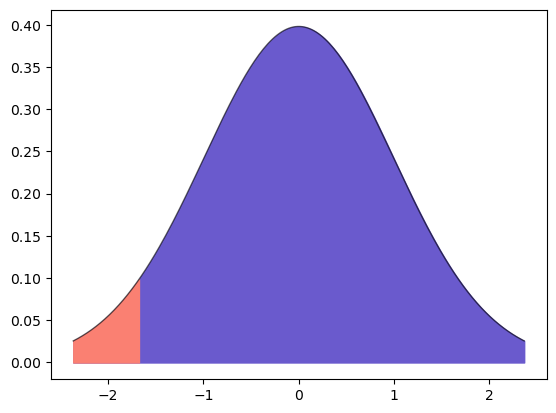

In [15]:
params = {"df": 101.286, "lb": 0.05, "ub": 1}
pc = rsm.basics.prob_calc(distribution="t", params=params)
pc.summary()
pc.plot()

In addition to the numerical output provided in the Summary tab we can also investigate the association between `rank` and `salary` visually (see the Plot tab). The screen shot below shows a scatter plot of professor salaries. Consistent with the results shown in the Summary tab there is clear separation between the salaries across ranks. We could also choose to plot the sample data as a box plot or as a set of density curves.

<p align="center">
<img src="figures_basics/compare_means_plot.png">
</p>

# Multiple comparison adjustment

The more comparisons we evaluate the more likely we are to find a “significant” result just by chance even if the null hypothesis is true. If we conduct 100 tests and set our **significance level** at 0.05 (or 5%) we can expect to find 5 p.values smaller than or equal to 0.05 even if the are no associations in the population.

Bonferroni adjustment ensures the p.values are scaled appropriately given the number of tests conducted.
<a href="https://xkcd.com/882/" target="blank">This XKCD cartoon</a> expresses the need for this type of adjustments very clearly.

# <i>Stats Speak</i>

This is a **comparison of means** test of the null hypothesis that the true population **difference in means** is equal to **0**. Using a significance level of 0.05, we reject the null hypothesis for each pair of ranks evaluated, and conclude that the true population **difference in means** is **less** than **0**.

The p.value for the test of differences in salaries between assistant and associate professors is **< .001**. This is the probability of observing a sample **difference in means** that is as or more extreme than the sample **difference in means** from the data if the null hypothesis is true. In this case, it is the probability of observing a sample **difference in means** that is less than (or equal to) **-13100.45** if the true population **difference in means** is **0**.

The 95% confidence bound is **-9785.958**. If repeated samples were taken and the 95% confidence bound computed for each one, the true population mean would be below the lower bound in 95% of the samples.

<sup>1</sup> The <b>significance level</b>, often denoted by α, is the highest probability you are willing to accept of rejecting the null hypothesis when it is actually true. A commonly used significance level is 0.05 (or 5%)

# Video Tutorials

To review the same analysis in Radiant for R, copy-and-paste the full command below into the RStudio console (i.e., the bottom-left window) and press return to gain access to all materials used in the hypothesis testing module of the <a href="https://www.youtube.com/playlist?list=PLNhtaetb48EdKRIY7MewCyvb_1x7dV3xw" target="_blank">Radiant Tutorial Series</a>:

`usethis::use_course("https://www.dropbox.com/sh/0xvhyolgcvox685/AADSppNSIocrJS-BqZXhD1Kna?dl=1")`

<a href="https://youtu.be/cTWk0JADnVg" target="_blank">Compare Means Hypothesis Test</a>

* This video shows how to conduct a compare means hypothesis test
* Topics List:
    - Calculate summary statistics by groups
    - Setup a hypothesis test for compare means in Radiant
    - Use the p.value and confidence interval to evaluate the hypothesis test

© Vincent Nijs (2023)